In [1]:
from scipy.io import loadmat

In [2]:
import numpy as np
from scipy.linalg import expm, logm

In [3]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
plt.style.use('seaborn-white')

In [5]:
data_odor = loadmat('/Users/linggeli/neuroscience/data/SuperChris/super_chris_extraction_odor2s.mat')

In [6]:
trial_info = data_odor['trialInfo']
select_odor_A = (trial_info[:, 0] == 1) & (trial_info[:, 1] == 1) & (trial_info[:, 3] == 1)
select_odor_B = (trial_info[:, 0] == 1) & (trial_info[:, 1] == 1) & (trial_info[:, 3] == 2)

In [7]:
lfp_odor_A = data_odor['lfpEpoch'][select_odor_A, 2000:4000, :]
lfp_odor_B = data_odor['lfpEpoch'][select_odor_B, 2000:4000, :]

In [8]:
lfp_data = np.concatenate([lfp_odor_A[:10, :, 5:10], lfp_odor_B[:10, :, 5:10]])

In [9]:
print(lfp_data.shape)

(20, 2000, 5)


In [10]:
cov_series = np.zeros((20, 100, 5, 5))  # time series of covariance matrices
utv_series = np.zeros((20, 100, 15))  # time series of upper triangular vector
for i in range(20):
    for t in range(100):
        lfp_window = lfp_data[i, (t * 10):(t * 10 + 50), :]
        cov = np.cov(lfp_window, rowvar=False)
        cov_series[i, t, :, :] = cov
        utv = logm(cov)[np.triu_indices(5)]
        utv_series[i, t, :] = utv

In [11]:
mean_series_A = np.mean(utv_series[:10, :, :], axis=0)
print(mean_series_A.shape)
mean_series_B = np.mean(utv_series[10:, :, :], axis=0)
print(mean_series_B.shape)

(100, 15)
(100, 15)


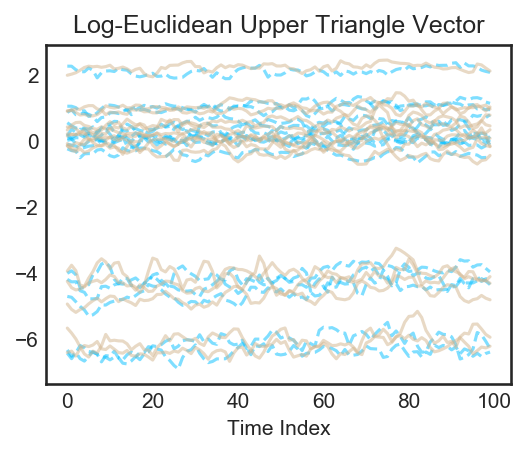

In [12]:
fig = plt.figure(figsize=(4, 3), dpi=150)
for j in range(15):
    plt.plot(mean_series_A[:, j], '--', color='deepskyblue', alpha=0.5)
for j in range(15):
    plt.plot(mean_series_B[:, j], color='tan', alpha=0.5)
plt.title('Log-Euclidean Upper Triangle Vector')
plt.xlabel('Time Index')
#plt.savefig('logeuclidean.png')
plt.show()

In [13]:
separation = np.mean((mean_series_A - mean_series_B) ** 2, axis=1)

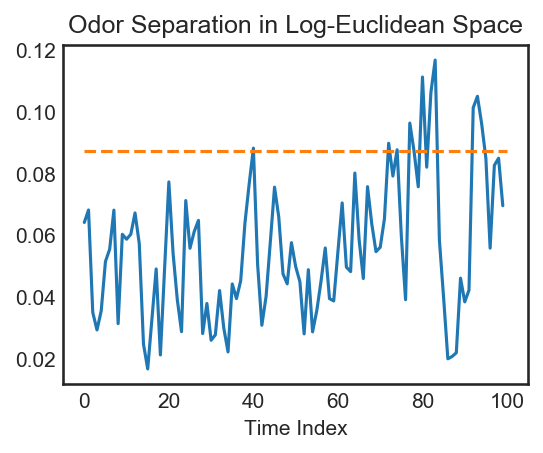

In [14]:

fig = plt.figure(figsize=(4, 3), dpi=150)
plt.plot(separation)
plt.plot([0, 100], [np.percentile(separation, 90), np.percentile(separation, 90)], '--')
plt.title('Odor Separation in Log-Euclidean Space')
plt.xlabel('Time Index')
#plt.savefig('separation1.png')
plt.show()

In [15]:
X = utv_series.reshape((2000, 15))
print(X.shape)

(2000, 15)


In [16]:
from sklearn.decomposition import PCA

In [17]:
latent_dim = 4

In [18]:
pca = PCA(n_components=latent_dim)
components = pca.fit_transform(X)

In [19]:
print(components.shape)

(2000, 4)


In [20]:
print(pca.explained_variance_ratio_)
print(np.sum(pca.explained_variance_ratio_))

[0.22387794 0.16873021 0.13356954 0.08002065]
0.6061983486049702


In [21]:
X_hat = pca.inverse_transform(components)
mse = np.mean((X - X_hat) ** 2)
print(mse)

0.10108492613722384


In [22]:
components_A = components[:1000, :].reshape((10, 100, 4))
mean_components_A = np.mean(components_A, axis=0)
print(mean_components_A.shape)
components_B = components[1000:, :].reshape((10, 100, 4))
mean_components_B = np.mean(components_B, axis=0)
print(mean_components_B.shape)

(100, 4)
(100, 4)


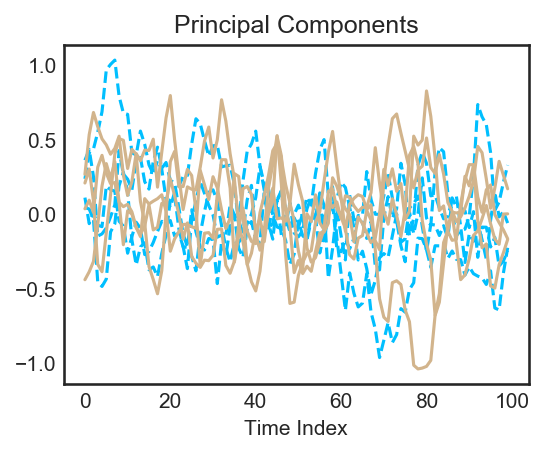

In [23]:
fig = plt.figure(figsize=(4, 3), dpi=150)

plt.plot(mean_components_A[:, 0], '--', color='deepskyblue')
plt.plot(mean_components_A[:, 1], '--', color='deepskyblue')
plt.plot(mean_components_A[:, 2], '--', color='deepskyblue')
plt.plot(mean_components_A[:, 3], '--', color='deepskyblue')

plt.plot(mean_components_B[:, 0], color='tan')
plt.plot(mean_components_B[:, 1], color='tan')
plt.plot(mean_components_B[:, 2], color='tan')
plt.plot(mean_components_B[:, 3], color='tan')

plt.title('Principal Components')
plt.xlabel('Time Index')
#plt.savefig('principal.png')
plt.show()

In [24]:
separation = np.mean((mean_components_A - mean_components_B) ** 2, axis=1)

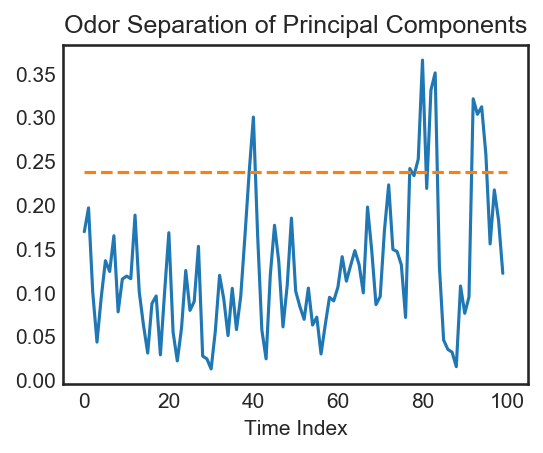

In [25]:
fig = plt.figure(figsize=(4, 3), dpi=150)
plt.plot(separation)
plt.plot([0, 100], [np.percentile(separation, 90), np.percentile(separation, 90)], '--')
plt.title('Odor Separation of Principal Components')
plt.xlabel('Time Index')
#plt.savefig('separation2.png')
plt.show()

In [26]:
from sklearn.linear_model import LinearRegression

In [27]:
def estimate_loading(X, F):
    """
    Estimate factor loading matrix given observations X and latent factors F.
    """
    n, q = X.shape
    n, r = F.shape
    loading_matrix = np.zeros((r, q))
    for j in range(q):
        loading_model = LinearRegression(fit_intercept=False).fit(F, X[:, j])
        loading_matrix[:, j] = loading_model.coef_
    return loading_matrix

In [28]:
def estimate_factors(X, W):
    """
    Estimate factors F given observations X and loading matrix W.
    """
    n, q = X.shape
    r, q = W.shape
    factors = np.zeros((n, r))
    regressor = np.transpose(W)
    for i in range(n):
        factor_model = LinearRegression(fit_intercept=False).fit(regressor, X[i, :])
        factors[i, :] = factor_model.coef_
    return factors

In [29]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern, ConstantKernel

In [30]:
def estimate_gp_params(design_matrix, latent_factor, verbose=True):
    kernel = ConstantKernel() * Matern(length_scale=0.1, length_scale_bounds=(0.1, 0.2), nu=1.5) \
    + WhiteKernel(noise_level=0.1, noise_level_bounds=(0.001, 1.0))
    model = GaussianProcessRegressor(kernel=kernel).fit(design_matrix, latent_factor)
    if verbose:
        print(model.kernel_)
    posterior_mean = model.predict(design_matrix)
    return np.exp(model.kernel_.theta)

In [31]:
def estimate_epoch_factor(gp_params, design_epoch, latent_epoch):
    kernel = ConstantKernel(constant_value=gp_params[0], constant_value_bounds='fixed') \
    * Matern(length_scale=gp_params[1], length_scale_bounds='fixed', nu=1.5) \
    + WhiteKernel(noise_level=gp_params[2], noise_level_bounds='fixed')
    epoch_model = GaussianProcessRegressor(kernel=kernel).fit(design_epoch, latent_epoch)
    posterior_epoch = epoch_model.predict(design_epoch)
    return posterior_epoch

In [32]:
def estimate_gp_factor(latent_factor):
    gp_factor = np.zeros(2000)
    design_matrix = np.zeros((2000, 22))
    time = np.linspace(0, 1, 100)
    design_matrix[:, 0] = np.tile(time, 20)
    design_matrix[1000:, 1] = 1e6  # no information sharing between odors
    for i in range(20):
        design_matrix[(i * 100):(i * 100 + 100), i + 2] = 0.1  # some information sharing across same odor epochs
    gp_params = estimate_gp_params(design_matrix, latent_factor)
    for i in range(20):
        design_epoch = np.linspace(0, 1, 100).reshape((100, 1))
        latent_epoch = latent_factor[(i * 100):(i * 100 + 100)]
        gp_factor[(i * 100):(i * 100 + 100)] = estimate_epoch_factor(gp_params, design_epoch, latent_epoch)
    return gp_factor

0.444**2 * Matern(length_scale=0.1, nu=1.5) + WhiteKernel(noise_level=0.002)
0.631**2 * Matern(length_scale=0.1, nu=1.5) + WhiteKernel(noise_level=0.00713)
0.479**2 * Matern(length_scale=0.1, nu=1.5) + WhiteKernel(noise_level=0.00503)
0.489**2 * Matern(length_scale=0.1, nu=1.5) + WhiteKernel(noise_level=0.00427)
0.1401965310510812


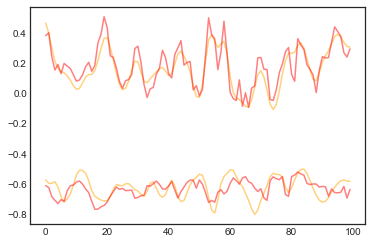

0.274**2 * Matern(length_scale=0.137, nu=1.5) + WhiteKernel(noise_level=0.001)
0.678**2 * Matern(length_scale=0.1, nu=1.5) + WhiteKernel(noise_level=0.00566)
0.461**2 * Matern(length_scale=0.1, nu=1.5) + WhiteKernel(noise_level=0.00188)
0.517**2 * Matern(length_scale=0.1, nu=1.5) + WhiteKernel(noise_level=0.0028)
0.12282606255689131


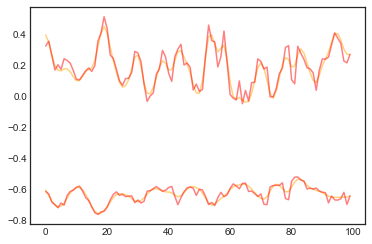

0.267**2 * Matern(length_scale=0.146, nu=1.5) + WhiteKernel(noise_level=0.001)
0.644**2 * Matern(length_scale=0.1, nu=1.5) + WhiteKernel(noise_level=0.00422)
0.527**2 * Matern(length_scale=0.1, nu=1.5) + WhiteKernel(noise_level=0.00171)
0.525**2 * Matern(length_scale=0.1, nu=1.5) + WhiteKernel(noise_level=0.00245)
0.11740764467906853


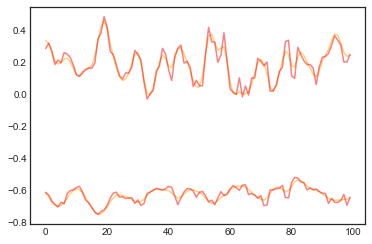

0.257**2 * Matern(length_scale=0.163, nu=1.5) + WhiteKernel(noise_level=0.001)
0.581**2 * Matern(length_scale=0.1, nu=1.5) + WhiteKernel(noise_level=0.00323)
0.564**2 * Matern(length_scale=0.1, nu=1.5) + WhiteKernel(noise_level=0.00168)
0.52**2 * Matern(length_scale=0.1, nu=1.5) + WhiteKernel(noise_level=0.00223)
0.11549359494471316


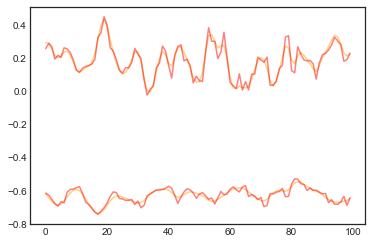

0.248**2 * Matern(length_scale=0.19, nu=1.5) + WhiteKernel(noise_level=0.001)
0.519**2 * Matern(length_scale=0.1, nu=1.5) + WhiteKernel(noise_level=0.0025)
0.57**2 * Matern(length_scale=0.1, nu=1.5) + WhiteKernel(noise_level=0.00162)
0.505**2 * Matern(length_scale=0.1, nu=1.5) + WhiteKernel(noise_level=0.00204)
0.11466621458154647


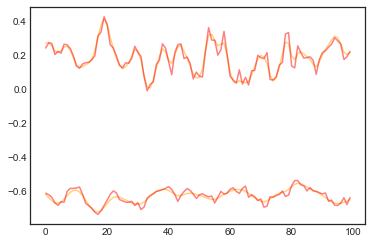

In [33]:
#F = components
W = np.random.normal(0, 1, 15 * latent_dim).reshape((latent_dim, 15))
F = estimate_factors(X, W)

for i in range(5):
    gp_factors = np.zeros((2000, latent_dim))  # estimate GP given latent factors
    for j in range(latent_dim):
        gp_factors[:, j] = estimate_gp_factor(F[:, j])
    F = gp_factors  # update latent factors with GP
    W = estimate_loading(X, F)  # update loading matrix and factors again
    F = estimate_factors(X, W)
    
    X_hat = np.dot(F, W)
    mse = np.mean((X - X_hat) ** 2)
    print(mse)
    
    plt.plot(gp_factors[:100, 0], color='orange', alpha=0.5)
    plt.plot(gp_factors[:100, 1], color='orange', alpha=0.5)
    #plt.plot(gp_factors[:100, 2], color='orange', alpha=0.5)
    #plt.plot(gp_factors[:100, 3], color='orange', alpha=0.5)
    
    plt.plot(F[:100, 0], color='red', alpha=0.5)
    plt.plot(F[:100, 1], color='red', alpha=0.5)
    #plt.plot(F[:100, 2], color='red', alpha=0.5)
    #plt.plot(F[:100, 3], color='red', alpha=0.5)
    plt.show()

In [107]:
factors_A = gp_factors[:1000, :].reshape((10, 100, 4))
mean_factors_A = np.mean(factors_A, axis=0)
print(mean_factors_A.shape)
factors_B = gp_factors[1000:, :].reshape((10, 100, 4))
mean_factors_B = np.mean(factors_B, axis=0)
print(mean_factors_B.shape)

(100, 4)
(100, 4)


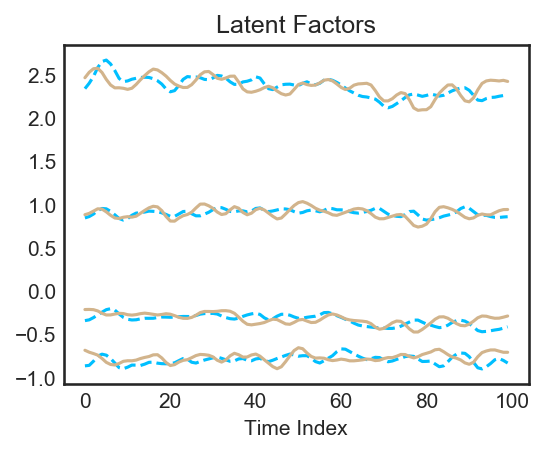

In [108]:
fig = plt.figure(figsize=(4, 3), dpi=150)

plt.plot(mean_factors_A[:, 0], '--', color='deepskyblue')
plt.plot(mean_factors_A[:, 1], '--', color='deepskyblue')
plt.plot(mean_factors_A[:, 2], '--', color='deepskyblue')
plt.plot(mean_factors_A[:, 3], '--', color='deepskyblue')

plt.plot(mean_factors_B[:, 0], color='tan')
plt.plot(mean_factors_B[:, 1], color='tan')
plt.plot(mean_factors_B[:, 2], color='tan')
plt.plot(mean_factors_B[:, 3], color='tan')

plt.title('Latent Factors')
plt.xlabel('Time Index')
#plt.savefig('factor.png')
plt.show()

In [109]:
separation = np.mean((mean_factors_A - mean_factors_B) ** 2, axis=1)

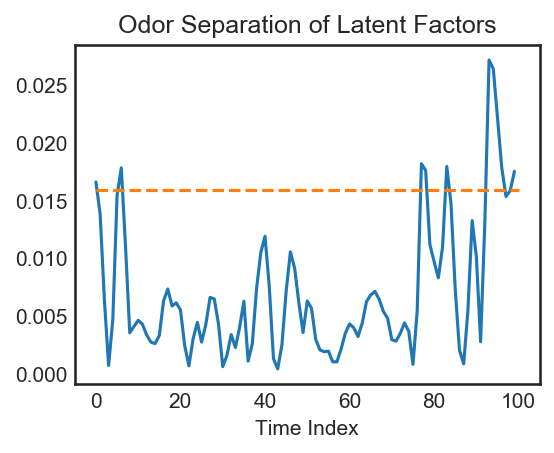

In [110]:
fig = plt.figure(figsize=(4, 3), dpi=150)
plt.plot(separation)
plt.plot([0, 100], [np.percentile(separation, 90), np.percentile(separation, 90)], '--')
plt.title('Odor Separation of Latent Factors')
plt.xlabel('Time Index')
#plt.savefig('separation3.png')
plt.show()